In [1]:
from dotenv import load_dotenv
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import warnings
import humanize
import missingno as msno
import pymongo
import requests
import os

In [2]:
load_dotenv()

sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80

warnings.filterwarnings("ignore")

In [3]:
def format_tick_humanize(value, tick_number):
    return humanize.intword(value)

In [4]:
response = requests.get('https://gis.transmilenio.gov.co/arcgis/rest/services/Troncal/consulta_estaciones_troncales/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json').json()
troncal_transmilenio = pd.DataFrame(response['features'])
troncal_transmilenio = pd.json_normalize(troncal_transmilenio['attributes'])
troncal_transmilenio.head(3)

objectid numero_estacion nombre_estacion  coordenada_x_estacion  \
0        11           07106    Campín - UAN           9.998678e+05   
1        12           10008       San Diego           1.000667e+06   
2        14           07111  Ricaurte - NQS           9.981846e+05   

   coordenada_y_estacion ubicacion_estacion troncal_estacion  \
0           1.005440e+06        Kr 30 Cl 53              NQS   
1           1.001625e+06      Kra 10- CL 23          Cr 7-10   
2           1.001712e+06        Kr 30 Cl 10              NQS   

   numero_vagones_estacion  numero_accesos_estacion biciestacion_estacion  \
0                        2                        2                     0   
1                        2                        2                     0   
2                        3                        2                     1   

   ...  codigo_nodo_estacion  componente_wifi  componente_aplificacion  \
0  ...                  7106             None                     None   
1  ...                 10008             None                     None   
2  ...                  7111             None                     None   

                                 globalid  created_user  created_date  \
0  {C7FE97EC-5E36-4B70-BCF3-09944D46C204}          None           NaN   
1  {7864D35D-5E80-40CF-94A1-ED91FC8B3DCF}          None           NaN   
2  {26DB3027-7F24-436B-B25C-8B791E9274A1}          None           NaN   

  last_edited_user last_edited_date log_replica id_trazado_troncal  
0    editorTroncal    1722866220000        None              TZ008  
1    editorTroncal    1722866220000        None              TZ018  
2    editorTroncal    1722866221000        None              TZ008  

[3 rows x 25 columns]

In [5]:
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

apartments = pd.DataFrame(list(collection.find()))
apartments = apartments.drop(columns=['_id', 'precio_venta'], axis=1)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'ARRIENDO') & (apartments['coords_modified'] == False) & (apartments['area'] > 0)]

apartments.shape

(8750, 48)

In [6]:
# apartments = pd.read_csv('../../data/processed/apartments.csv')
# apartments = apartments[apartments['tipo_operacion'] == 'ARRIENDO']
# apartments = apartments.drop(columns=['precio_venta'])
# apartments.shape

In [7]:
chapinero = apartments.loc[apartments['localidad'] == 'CHAPINERO']
chapinero.head(3)

codigo  administracion          antiguedad   area  ascensor  \
366  10139-M5045866       2106000.0  ENTRE 10 Y 20 ANOS  140.0         1   
367  19983-M5769112       1180000.0   ENTRE 5 Y 10 ANOS  125.0         0   
368   5545-M5598904             NaN  ENTRE 10 Y 20 ANOS   85.0         1   

     banos                       barrio  \
366      3              S.C. BELLAVISTA   
367      3                  LOS ROSALES   
368      2  S.C. CHICO NORTE III SECTOR   

                        centro_comercial_cercano  chimenea closets  ...  \
366  CENTRO COMERCIAL Y FINANCIERO AVENIDA CHILE         0    None  ...   
367  CENTRO COMERCIAL Y FINANCIERO AVENIDA CHILE         0    None  ...   
368      CENTRO COMERCIAL Y FINANCIERO CENTRO 93         1    None  ...   

    precio_arriendo  salon_comunal  sector terraza timeline tipo_operacion  \
366       9000000.0              0   CHICO       1     None       ARRIENDO   
367       6620000.0              0   CHICO       1     None       ARRIENDO   
368       5000000.0              0   CHICO       1     None       ARRIENDO   

     tipo_propiedad   url  vigilancia            website  
366     APARTAMENTO  None           1  metrocuadrado.com  
367     APARTAMENTO  None           1  metrocuadrado.com  
368     APARTAMENTO  None           1  metrocuadrado.com  

[3 rows x 48 columns]

In [8]:
chapinero.shape

(3071, 48)

In [9]:
chapinero = chapinero.drop(chapinero[chapinero['area'] == 0].index)
chapinero.shape

(3071, 48)

In [10]:
chapinero[['precio_arriendo', 'administracion', 'area']].describe().T.applymap(lambda x: humanize.intword(x))

count          mean            std             min  \
precio_arriendo  3.1 thousand  15.7 million  181.7 million  900.0 thousand   
administracion   2.3 thousand   4.7 million  139.1 million               1   
area             3.1 thousand           167            113              15   

                            25%          50%           75%           max  
precio_arriendo     4.5 million  8.0 million  13.0 million   9.5 billion  
administracion   732.0 thousand  1.3 million   2.0 million   6.7 billion  
area                         80          147           230  1.3 thousand

# Eliminar Outliers

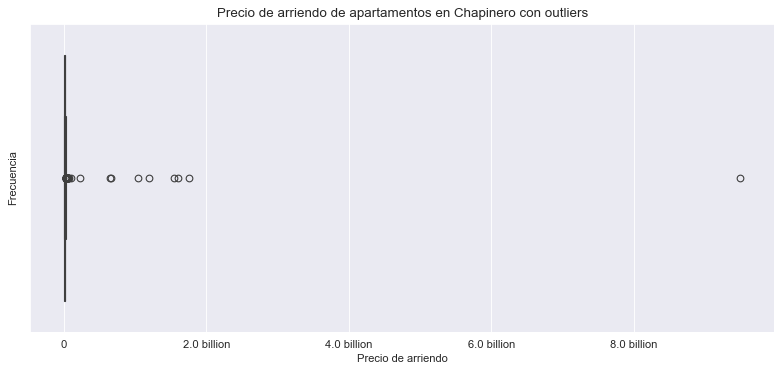

In [11]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    x='precio_arriendo',
    data=chapinero
)

plt.title('Precio de arriendo de apartamentos en Chapinero con outliers')
plt.xlabel('Precio de arriendo')
plt.ylabel('Frecuencia')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [12]:
iqr = stats.iqr(chapinero['precio_arriendo'])
q1 = np.percentile(chapinero['precio_arriendo'], 25)
q3 = np.percentile(chapinero['precio_arriendo'], 75)

outlier_threshold = 1.5

lower_bound = q1 - (outlier_threshold * iqr)
upper_bound = q3 + (outlier_threshold * iqr)

outliers = chapinero.loc[(chapinero['precio_arriendo'] < lower_bound) | (chapinero['precio_arriendo'] > upper_bound)]
outliers.shape

(109, 48)

In [13]:
outliers['precio_arriendo'].describe().apply(lambda x: humanize.intword(x)).to_frame().T

count           mean            std           min  \
precio_arriendo   109  198.4 million  950.3 million  26.0 million   

                          25%           50%           75%          max  
precio_arriendo  28.0 million  32.0 million  41.0 million  9.5 billion

In [14]:
chapinero = chapinero.drop(outliers.index)
chapinero.drop(chapinero[chapinero['codigo'] == '11301-M4069724'].index, inplace=True)
chapinero.drop(chapinero[chapinero['codigo'] == '4796-3142'].index, inplace=True)
chapinero.shape

(2962, 48)

# Analisis Rapido

In [15]:
chapinero[['precio_arriendo', 'administracion', 'area']].describe().T.applymap(lambda x: humanize.intword(x))

count         mean            std             min  \
precio_arriendo  3.0 thousand  9.0 million    5.6 million  900.0 thousand   
administracion   2.2 thousand  4.7 million  141.8 million               1   
area             3.0 thousand          159            102              15   

                            25%          50%           75%           max  
precio_arriendo     4.5 million  7.9 million  12.0 million  25.3 million  
administracion   721.0 thousand  1.3 million   1.9 million   6.7 billion  
area                         79          140           218  1.3 thousand

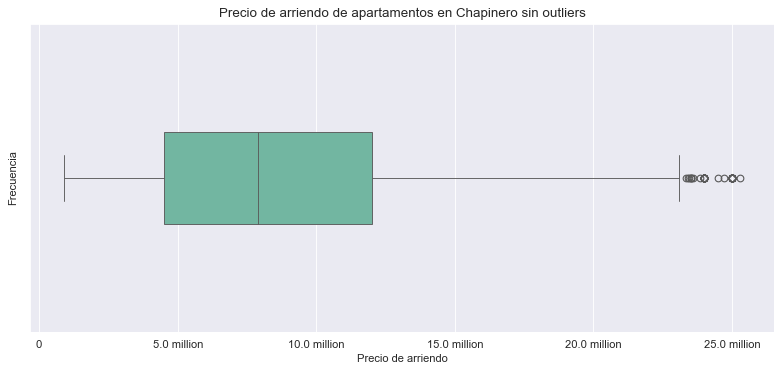

In [16]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    x='precio_arriendo',
    data=chapinero,
    width=.3,
    palette='Set2',
    linewidth=.8,
)

plt.title('Precio de arriendo de apartamentos en Chapinero sin outliers')
plt.xlabel('Precio de arriendo')
plt.ylabel('Frecuencia')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

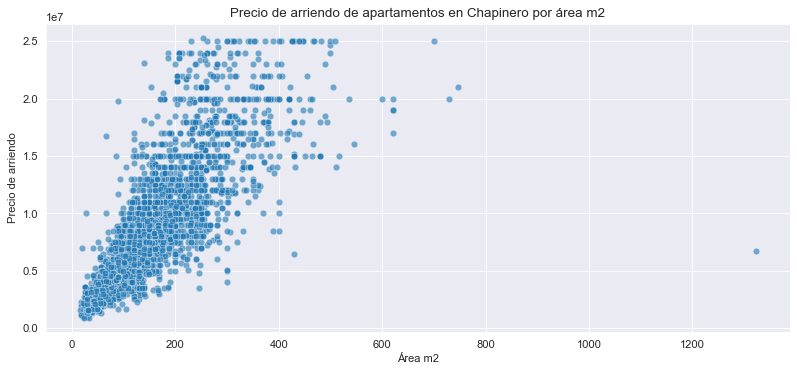

In [17]:
plt.figure(figsize=(12, 5))
    
sns.scatterplot(
    x='area',
    y='precio_arriendo',
    data=chapinero,
    alpha=0.6,
)

plt.title('Precio de arriendo de apartamentos en Chapinero por área m2')
plt.xlabel('Área m2')
plt.ylabel('Precio de arriendo')
plt.show()

In [18]:
fig = px.scatter_mapbox(
    chapinero,
    lat='latitud',
    lon='longitud',
    color='precio_arriendo',
    # size='area',
    size_max=15,
    zoom=12,
    hover_name='barrio',
    hover_data=['area', 'estrato', 'habitaciones', 'banos', 'parqueaderos', 'administracion', 'precio_arriendo', 'codigo'],
    color_continuous_scale=px.colors.sequential.Viridis,
    height=600,
)

fig.update_layout(
    mapbox=dict(
        accesstoken=os.getenv('MAPBOX_TOKEN'),
        center=dict(lat=4.656, lon=-74.059),
        style='dark',
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    # title='Precio de arriendo por barrio en Chapinero',
)

fig.show()

In [19]:
fig = ff.create_hexbin_mapbox(
    data_frame=chapinero,
    lat='latitud',
    lon='longitud',
    nx_hexagon=12,
    opacity=.6,
    min_count=1,
    labels={'color': 'Precio de arriendo'},
    color='precio_arriendo',
    color_continuous_scale=px.colors.sequential.Viridis,
    zoom=12,
    height=600,
)

fig.update_layout(
    mapbox=dict(
        accesstoken=os.getenv('MAPBOX_TOKEN'),
        center=dict(lat=4.656, lon=-74.059),
        style='dark',
    ),
    margin=dict(l=0, r=0, t=0, b=0),
)

fig.show()

In [20]:
chapinero.columns

Index(['codigo', 'administracion', 'antiguedad', 'area', 'ascensor', 'banos',
       'barrio', 'centro_comercial_cercano', 'chimenea', 'closets', 'compañia',
       'conjunto_cerrado', 'coords_modified', 'datetime', 'descripcion',
       'direccion', 'distancia_centro_comercial_m', 'distancia_estacion_tm_m',
       'distancia_parque_m', 'estacion_tm_cercana', 'estado', 'estrato',
       'gimnasio', 'habitaciones', 'is_cerca_centro_comercial',
       'is_cerca_estacion_tm', 'is_cerca_parque', 'jacuzzi', 'last_view',
       'latitud', 'localidad', 'longitud', 'midinmueble', 'parque_cercano',
       'parqueaderos', 'permite_mascotas', 'piscina', 'piso',
       'precio_arriendo', 'salon_comunal', 'sector', 'terraza', 'timeline',
       'tipo_operacion', 'tipo_propiedad', 'url', 'vigilancia', 'website'],
      dtype='object')

In [21]:
fig = ff.create_hexbin_mapbox(
    data_frame=chapinero,
    lat='latitud',
    lon='longitud',
    nx_hexagon=12,
    opacity=.6,
    min_count=1,
    labels={'color': 'Precio de arriendo'},
    color='precio_arriendo',
    color_continuous_scale=px.colors.sequential.Viridis,
    zoom=12,
    height=600,
)

fig.add_trace(
    go.Scattermapbox(
        lat=troncal_transmilenio['latitud_estacion'],
        lon=troncal_transmilenio['longitud_estacion'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='red',
            allowoverlap=True,
        ),
        text=troncal_transmilenio['nombre_estacion'],
        hoverinfo='text',
    )
)

fig.update_layout(
    mapbox=dict(
        accesstoken=os.getenv('MAPBOX_TOKEN'),
        center=dict(lat=4.656, lon=-74.059),
        style='dark',
    ),
    margin=dict(l=0, r=0, t=0, b=0),
)

fig.show()

In [22]:
parques = pd.read_csv('../../data/external/espacios_para_deporte_bogota/directorio-parques-y-escenarios-2023-datos-abiertos-v1.0.csv')
parques.head()

No. LOCALIDAD TIPO DE PARQUE  NOMBRE DEL PARQUE O ESCENARIO  \
0    1   USAQUEN          ZONAL                    ALTA BLANCA   
1    2   USAQUEN        VECINAL  DESARROLLO ESTRELLA DEL NORTE   
2    3   USAQUEN        VECINAL          DESARROLLO VERBENAL I   
3    4   USAQUEN  METROPOLITANO                     EL COUNTRY   
4    5   USAQUEN          ZONAL                        LA VIDA   

                   DIRECCIÓN   LATITUD   LONGITUD  
0         Carrera 8A #158-04  4.734315 -74.028784  
1         Calle 159A #19B-60  4.739635 -74.045056  
2           Calle 187 #19-22  4.764861 -74.040240  
3  Avenida Calle 127 #11D-90  4.704366 -74.038504  
4        Carrera 14A #157-98  4.738300 -74.037140

In [23]:
fig = px.scatter_mapbox(
    chapinero,
    lat='latitud',
    lon='longitud',
    color='precio_arriendo',
    # size='area',
    size_max=15,
    zoom=12,
    hover_name='barrio',
    hover_data=['area', 'estrato', 'habitaciones', 'banos', 'parqueaderos', 'administracion', 'precio_arriendo', 'codigo'],
    color_continuous_scale=px.colors.sequential.Viridis,
    # color_continuous_scale=px.colors.cyclical.IceFire,
    height=600,
)

fig.add_trace(
    go.Scattermapbox(
        lat=parques['LATITUD'],
        lon=parques['LONGITUD'],
        mode='markers',
        name='Parques',
        marker=go.scattermapbox.Marker(
            size=12,
            color='green',
            allowoverlap=True,
        ),
        text='PARQUE ' + parques['TIPO DE PARQUE'] + ' ' + parques['NOMBRE DEL PARQUE O ESCENARIO'],
        hoverinfo='text',
        hovertemplate='Parque:  %{text}',
        showlegend=True
    )
)

fig.update_layout(
    mapbox=dict(
        accesstoken=os.getenv('MAPBOX_TOKEN'),
        center=dict(lat=4.656, lon=-74.059),
        style='dark',
    ),
    margin=dict(l=0, r=0, t=0, b=0),
)

fig.update_layout(
    legend=dict(
        yanchor='top',
        y=0.99,
        xanchor='left',
        x=0.01
    )
)

fig.show()